<a href="https://colab.research.google.com/github/anezovic1/bike-share-prediction/blob/main/DBSCAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mašinsko učenje 2023/24

## Projektni zadatak - Individualni zadatak

Algoritam klasteringa koji je odabran je **DBSCAN** (Density-Based Spatial Clustering of Applications with Noise) iz grupe metode zasnovane na gustoći.

# Zadatak 2

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/MU Projekat/Drugi dio/dataset/hour.csv')

In [ ]:
data.head(3)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32


## Predprocesiranje podataka

In [ ]:
# izdvajamo kolone od interesa
potrebne_kolone = ['dteday', 'temp', 'hum', 'windspeed', 'cnt']
new_data = data[potrebne_kolone]

# sabiramo sve vrijednosti da bismo na neki način dobili jedan broj koji predstavlja dnevno vrijeme
new_data.loc[:, 'UkupnoDnevnoVrijeme'] = new_data['temp'] + new_data['hum'] + new_data['windspeed']

# pošto su podaci dati za svaki sat svakog dana dvije godine
# potrebno je spojiti sve sate da bi se dobila samo jedna vrijednost za jedan dan
new_data = new_data.groupby('dteday').agg({'cnt': 'sum', 'UkupnoDnevnoVrijeme': 'sum'}).reset_index()

# vrijednosti se normaliziraju
scaler = MinMaxScaler()
column_values = new_data['UkupnoDnevnoVrijeme'].values.reshape(-1, 1)
new_data['UkupnoDnevnoVrijeme'] = scaler.fit_transform(column_values)

# promjena naziva kolona
new_data = new_data.rename(columns={'cnt': 'UkupanBrojRentanihB'})
new_data = new_data.rename(columns={'dteday': 'Datum'})

<ipython-input-30-c689e534c412>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data.loc[:, 'UkupnoDnevnoVrijeme'] = new_data['temp'] + new_data['hum'] + new_data['windspeed']


In [ ]:
new_data

,Datum,UkupanBrojRentanihB,UkupnoDnevnoVrijeme
0,2011-01-01,985,0.695556
1,2011-01-02,801,0.663683
2,2011-01-03,1349,0.414088
3,2011-01-04,1562,0.471653
4,2011-01-05,1600,0.417964
...,...,...,...
726,2012-12-27,2114,0.665710
727,2012-12-28,3095,0.520819
728,2012-12-29,1341,0.594736
729,2012-12-30,1796,0.571908


In [ ]:
karakteristike = new_data[['UkupnoDnevnoVrijeme', 'UkupanBrojRentanihB']].values
scaler = StandardScaler()
data_scaled = scaler.fit_transform(karakteristike)

In [ ]:
data_scaled

array([[ 0.03401722, -1.81795256],
       [-0.19366233, -1.91299949],
       [-1.9765819 , -1.62992496],
       ...,
       [-0.68616974, -1.63405743],
       [-0.84923189, -1.39902293],
       [-1.41693714, -0.91707305]])

## Određivanje parametara algoritma

Sljedeći korak jeste određivanje parametara DBSCAN algoritma, **epsilon** i **MinPts**.

Prilikom određivanja ovih parametara, korištena je **metoda graf najbližeg susjedstva**.

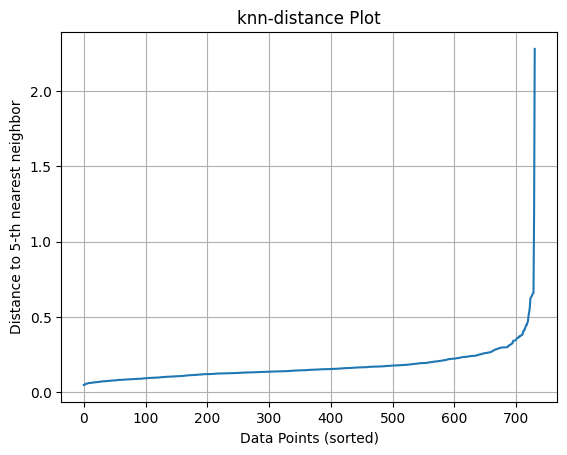

In [ ]:
k = 5
susjedi = NearestNeighbors(n_neighbors=k)
susjedi.fit(data_scaled)
distance, _ = susjedi.kneighbors()

sortirane_distance = np.sort(distance[:, -1])
plt.plot(np.arange(len(sortirane_distance)), sortirane_distance)
plt.title('knn-distance Plot')
plt.xlabel('Data Points (sorted)')
plt.ylabel(f'Distance to {k}-th nearest neighbor')
plt.grid(True)
plt.show()

In [ ]:
epsilon = 0.2
min_susjeda = 5

## Izgradnja modela

### Prvi prolaz

In [ ]:
dbscan = DBSCAN(eps=epsilon, min_samples=min_susjeda)
klasteri = dbscan.fit_predict(data_scaled)

In [ ]:
print("Cluster labels:", klasteri)
print("Number of clusters:", len(set(klasteri)) - (1 if -1 in klasteri else 0))

Cluster labels: [-1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0 -1 -1  0
  0  0 -1  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0 -1  0  0  0  1  0  0  1  0  0  0  0 -1 -1  0  0  0 -1  0  0  0
  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  1  0  0  0  0  1  0
  0  1  0  0  0 -1 -1  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0
  0  0  0  0  0  0  0 -1 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0
  0 -1  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0 -1 -1  0  0
  0  0  0 -1  0  0  0  0  0  0  0  2  0 -1  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0 -1  0  3  0  

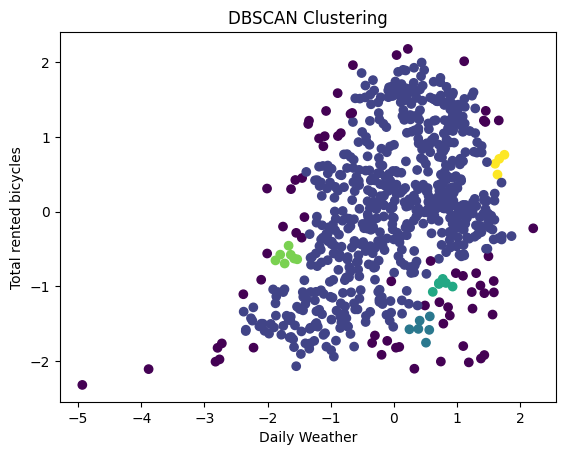

In [ ]:
plt.scatter(data_scaled[:, 0], data_scaled[:, 1], c=klasteri, cmap='viridis')
plt.title('DBSCAN Clustering')
plt.xlabel('Daily Weather')
plt.ylabel('Total rented bicycles')
plt.show()

In [ ]:
silhouette_avg = silhouette_score(data_scaled, klasteri)
print("Silhouette Score:", silhouette_avg)

Silhouette Score: -0.28994181399118624


### Drugi prolaz

In [ ]:
epsilon = 0.18
min_susjeda = 5

In [ ]:
dbscan = DBSCAN(eps=epsilon, min_samples=min_susjeda)
klasteri = dbscan.fit_predict(data_scaled)

In [ ]:
print("Cluster labels:", klasteri)
print("Number of clusters:", len(set(klasteri)) - (1 if -1 in klasteri else 0))

Cluster labels: [-1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  0  0 -1 -1  0
  0  0 -1  0  0  0  0  0 -1  0  0 -1  0  0  0  0  0  0  0  0 -1  0  0  0
  0  0  0 -1  0  0  0 -1  0  0 -1  0  0  0  0 -1 -1  0  0  0 -1  0  0  0
  0  0  0  0  0  0  0  1 -1  1  0  0  2  0  0  2  0 -1  0  0  0  0 -1  0
  0 -1  1 -1  0 -1 -1  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0
  0  0  0  0  0  0  0 -1 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0
  0 -1  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0 -1 -1  0  0
  0  0  0 -1  0  0  0  0  0  0  0  3  0 -1  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0 -1  0  4  0  

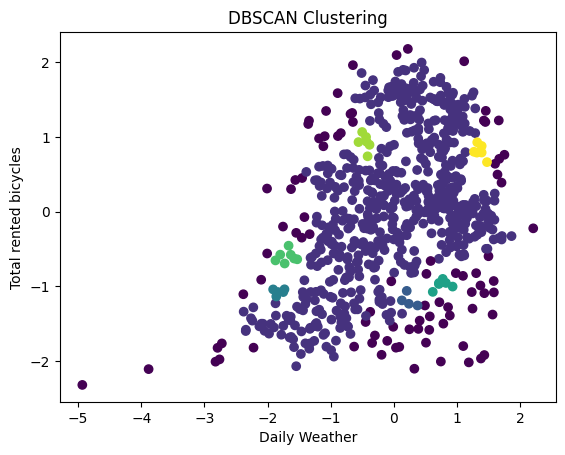

In [ ]:
plt.scatter(data_scaled[:, 0], data_scaled[:, 1], c=klasteri, cmap='viridis')
plt.title('DBSCAN Clustering')
plt.xlabel('Daily Weather')
plt.ylabel('Total rented bicycles')
plt.show()

In [ ]:
silhouette_avg = silhouette_score(data_scaled, klasteri)
print("Silhouette Score:", silhouette_avg)

Silhouette Score: -0.46055640491792255


### Treći prolaz

In [ ]:
epsilon = 0.3
min_susjeda = 20

In [ ]:
dbscan = DBSCAN(eps=epsilon, min_samples=min_susjeda)
klasteri = dbscan.fit_predict(data_scaled)

In [ ]:
print("Cluster labels:", klasteri)
print("Number of clusters:", len(set(klasteri)) - (1 if -1 in klasteri else 0))

Cluster labels: [-1 -1 -1  0 -1 -1 -1  0 -1 -1  0  0  0 -1  0  0  0 -1 -1  0  0 -1 -1 -1
  0 -1 -1  0  0  0  0  0 -1  0  0 -1  0  0  0 -1 -1 -1  0  0 -1 -1  0  1
 -1  0  0 -1 -1 -1 -1 -1  0 -1 -1  0  0 -1  0 -1 -1  0 -1 -1 -1 -1 -1  1
  0  0 -1  1  1  1  0 -1 -1 -1 -1  0 -1  0 -1 -1  0 -1 -1  1  1 -1 -1  1
  1 -1 -1 -1  1 -1 -1  1 -1 -1  1  1 -1  1  1 -1  1  1  1  1 -1  1  1  1
  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1
  1  1  1  1  1  1  1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1 -1  1  1  1  1  1  1  1 -1 -1  1  1  1  1  1  1  1  1  1 -1 -1  1  1
  1  1  1 -1  1  1  1  1  1  1  1 -1  1 -1  1  1  1  1  1  1  1  1  1  1
  1 -1  1  1  1  1  1 -1  1 -1  1  

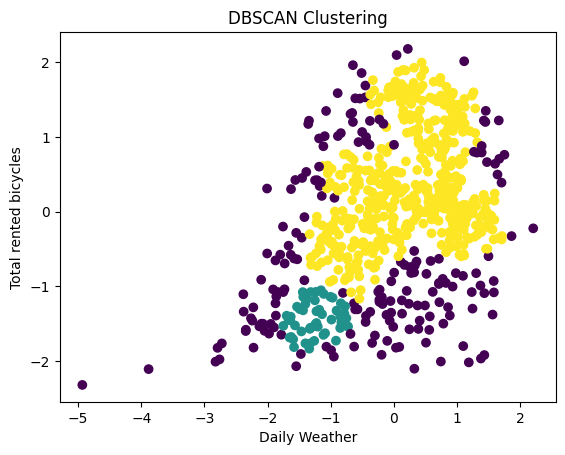

In [ ]:
plt.scatter(data_scaled[:, 0], data_scaled[:, 1], c=klasteri, cmap='viridis')
plt.title('DBSCAN Clustering')
plt.xlabel('Daily Weather')
plt.ylabel('Total rented bicycles')
plt.show()

In [ ]:
silhouette_avg = silhouette_score(data_scaled, klasteri)
print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.17700730193363617
